# Problema de Designação de Tarefas

<div style="text-align:justify">
O problema de designação de tarefas consiste em designar pessoas para realizar tarefas. Este experimento vai simular a designação de pessoas para projetos de software. Vamos considerar que as pessoas possuem características específicas, tais como: senioridade, conhecimento em tecnologias e idiomas. Por sua vez, as necessidades dos projetos de software possuem as mesmas características.
<br><br>
A designação deve maximizar a semelhança entre as características da pessoa e da necessidade, levando em consideração a urgência do projeto. A urgência do projeto leva em consideração o número de pessoas no squad, o número de pessoas necessárias e a data de abertura da necessidade.
</div>
<br>
<u>Premissas</u>:

- A computação considera que necessidades resolvidas foram retiradas da listagem
- Quando houver apenas uma necessidade e uma pessoa, a relação é resolvida pela designação direta

## Variáveis do Problema

Seja:<br>
- <code>p<sub>i</sub></code> = A <code>i-ésima</code> pessoa disponível para alocação
- <code>n<sub>j</sub></code> = A <code>j-ésima</code> necessidade de projeto
- <code>s<sub>ij</sub></code> = A similaridade entre a <code>p<sub>i</sub></code> e <code>n<sub>j</sub></code>
- <code>u<sub>j</sub></code> = A <code>j-ésima</code> urgência da necessidade
- <code>w<sub>ij</sub></code> = O fator de combinação entre <code>s<sub>ij</sub></code> e <code>u<sub>j</sub></code>
- <code>a<sub>ij</sub></code> = A matriz de ativação entre a <code>p<sub>i</sub></code> e <code>n<sub>j</sub> &isin; {0, 1}</code>
- <code>x<sub>ij</sub></code> = <code>x<sub>ij</sub> &isin; {0, 1}</code

#### Onde:

Obtemos a similaridade <code>s<sub>ij</sub></code> através relação dada pelo produto escalar: $$ AB = |A||B|cos(\theta) $$

logo,

$$ s_{ij} = cos(\theta) = \frac{AB}{|A||B|}= \frac{\sum_{i=0}^{n} A_i.B_i}{\sqrt{\sum_{i=0}^{n} A_i^2} \sqrt{\sum_{i=0}^{n} B_i^2}},\forall j=0...m$$

----

A urgência <code>u<sub>ij</sub></code> da necessidade é dada pela relação:

$$ u_j = \sum_{j=0}^{m} d_j * \frac{1}{30} - h_j * \frac{1}{t_j}$$

<div style="text-align:justify">
onde: <code>d<sub>j</sub><code> corresponde ao número de dias desde a abertura da necessidade, <code>h<sub>j</sub><code> ao número de pessoas do time atual e <code>t<sub>j</sub><code> ao número total de pessoas previsto.
</div>

----

$$ w_{ij} = \sum_{i=0}^{n} \sum_{j=0}^{m} s_{ij}+u_j $$

<div style="text-align:justify">
As similaridades <code>s<sub>ij</sub></code> são somadas as urgências <code>u<sub>j</sub></code> para compor o fator de combinação entre pessoas e necessidades. Obtemos <code>w<sub>ij</sub></code> a partir da soma destes coeficientes.
</div>

----

$$ a_{ij} = 1 \forall (c_i == k_j) $$

Produz uma matriz binária de ativação onde <code>c<sub>i</sub><code> é o papel da pessoa e <code>k<sub>j</sub><code> é o papel da vaga.

## Modelagem

Seja:

$$ max \sum_{i=0}^{n} \sum_{j=0}^m x_{ij}.w_{ij}.a_{ij} $$

onde pretendemos obter o fator de combinação máxima para <code>x<sub>ij</sub></code>, sob as restrições:

$$ c_1 = \sum_{j=0}^{m} x_{ij} \leq 1, \forall i=0...n $$

$$ c_2 = \sum_{i=0}^{n} x_{ij} \leq 1, \forall j=0...m $$

garantindo que cada pessoa será designada a apenas uma necessidade e vice-versa.

## Implementação

<div style="text-align:justify">
Vamos implementar uma situação exemplo para designar pessoas a projetos de software. Essa designação utiliza dados sintéticos, tanto para o perfil das pessoas quanto para o perfil das necessidades.
</div>

#### Carregando Dependências

In [1]:
import pandas
import gurobipy
import simulator

from datetime import datetime
from matplotlib import pyplot
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

#### Configurações

Configurações de exibição do `jupyter notebook`.

In [2]:
pyplot.rcParams['figure.figsize'] = (15, 8)

#### Carregando Dados

<div style="text-align:justify">
Os datasets utilizados nesse experimento foram criados para simular uma situação de designação. O arquivo <code>necessidades.csv</code> representa as necessidades abertas em projetos, enquanto o arquivo <code>pessoas.csv</code> contém as pessoas disponíveis para alocação. Os arquivos possuem dimensões em comum, que serão utilizadas para calcular a similaridade entre a pessoa e a necessidade. As dimensões comuns, são:
</div>

<div style="text-align:justify">
<code>skill_backend</code>, <code>skill_frontend</code>, <code>skill_java</code>, <code>skill_python</code>, <code>skill_spring</code>, <code>skill_reactjs</code>, <code>skill_angular</code>, <code>skill_dtaengineering</code>, <code>skill_datascience</code>, <code>skill_po</code>, <code>senior</code>, <code>pleno</code>, <code>junior</code>, <code>ing_avancado</code>, <code>ing_intermediario</code>, <code>ing_basico</code>.
</div>

<div style="text-align:justify">
As dimensões apresentadas acima não representam todas as habilidades necessárias para um cenário de similaridade. Estas dimensões devem ser ampliadas antes de serem aplicadas em um cenário real.
</div>

In [3]:
df_necessi = pandas.read_csv('datasets/necessidades.csv')
df_pessoas = pandas.read_csv('datasets/pessoas.csv')

#### Função de Urgência

<div style="text-align:justify">
A seguir, a função que calcula a urgência de uma necessidade. Essa é uma função linear, e sua taxa de inclinação está relacionada ao número de dias que a necessidade está aberta e ao tamanho atual da equipe, em relação ao tamanho esperado.
</div>

In [4]:
def fn_urgencia(nrd, tma, tms, tf=30):
    return (nrd / tf) - (tma / tms)

#### Análise Experimental de Decaimento

<div style="text-align:justify">
Para analisar o comportamento da função de urgência, vamos simular cenários onde três necessidades competem entre si pela alocação de pessoas. As necessidades com maior taxa de urgência tem maior chance de ser atendida. Nessa simulação, assumimos que as três necessidades tem as mesmas características e a mesma similiridade entre as pessoas.
</div>

----

<u>Teste: Cenário 1</u>:

- Necessidade 1: Um squad precisa de 10 desenvolvedores e já tem 4 alocados
- Necessidade 2: Um novo projeto está iniciando e precisa de um squad com 3 desenvolvedores
- Necessidade 3: Um novo projeto está iniciando e precisa de um squad com 50 desenvolvedores
<br><br>

Condições:

- As vagas foram abertas no mesmo dia
- Vamos analisar a variação da taxa de urgência ao longo de 30 dias corridos
- Contratamos a uma taxa constante de 2 pessoas por semana, para esse perfil demandado

Contratações:
Necessidade 1 - Esperado 10 Designado 4
Necessidade 2 - Esperado 3 Designado 1
Necessidade 3 - Esperado 50 Designado 8


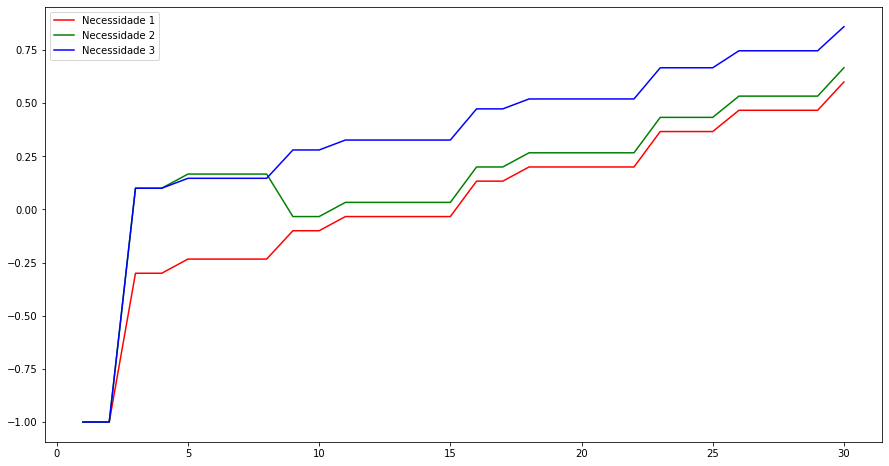

In [5]:
simulator.run(
    weekends = [1, 7, 8, 14, 15, 21, 22, 28, 29],
    hiring_days = [3, 5, 9, 11, 16, 18, 23, 26, 30],
    sqd_s1 = 10, sqd_s2 = 3, sqd_s3 = 50,
    sqd_a1 = 4, sqd_a2 = 0, sqd_a3 = 0,
    fn = fn_urgencia
)

----

<u>Teste: Cenário 2</u>:

Identico ao <u>Cenário de Teste 1</u>, mas o fluxo de contratação para o perfil demandado é 1 pessoa por semana.

Contratações:
Necessidade 1 - Esperado 10 Designado 4
Necessidade 2 - Esperado 3 Designado 1
Necessidade 3 - Esperado 50 Designado 4


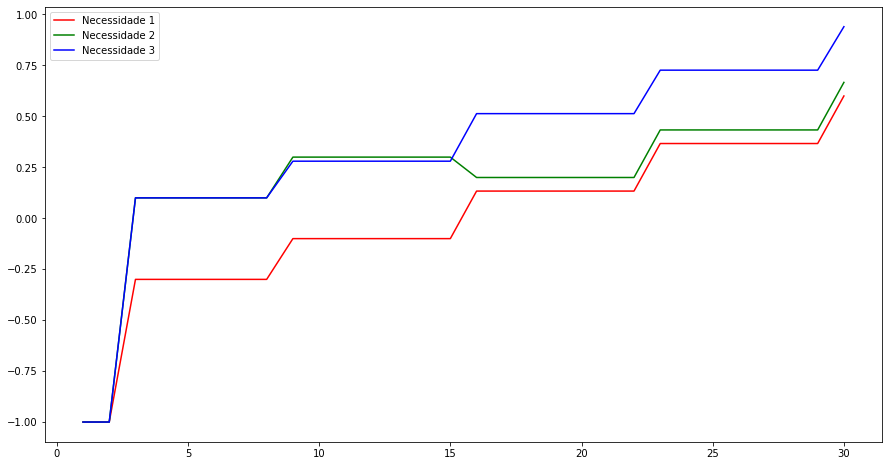

In [6]:
simulator.run(
    weekends = [1, 7, 8, 14, 15, 21, 22, 28, 29],
    hiring_days = [3, 9, 16, 23, 30],
    sqd_s1 = 10, sqd_s2 = 3, sqd_s3 = 50,
    sqd_a1 = 4, sqd_a2 = 0, sqd_a3 = 0,
    fn = fn_urgencia
)

----

<u>Teste: Cenário 3</u>:

- Necessidade 1: Um novo projeto está iniciando e precisa de um squad com 3 desenvolvedores
- Necessidade 2: Um novo projeto está iniciando e precisa de um squad com 10 desenvolvedores
- Necessidade 3: Um novo projeto está iniciando e precisa de um squad com 50 desenvolvedores
<br><br>

Condições:

- As vagas foram abertas no mesmo dia
- Vamos analisar a variação da taxa de urgência ao longo de 30 dias corridos
- Contratamos a uma taxa constante de 2 pessoas por semana, para esse perfil demandado

Contratações:
Necessidade 1 - Esperado 3 Designado 1
Necessidade 2 - Esperado 10 Designado 2
Necessidade 3 - Esperado 50 Designado 6


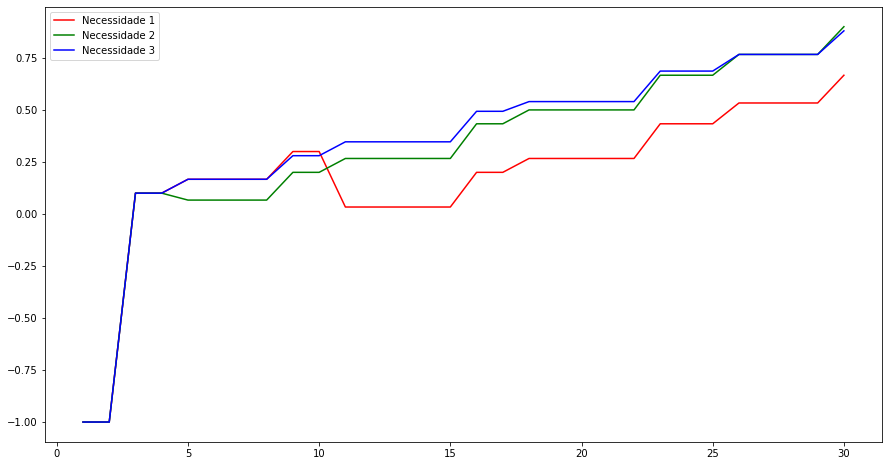

In [7]:
simulator.run(
    weekends = [1, 7, 8, 14, 15, 21, 22, 28, 29],
    hiring_days = [3, 5, 9, 11, 16, 18, 23, 26, 30],
    sqd_s1 = 3, sqd_s2 = 10, sqd_s3 = 50,
    sqd_a1 = 0, sqd_a2 = 0, sqd_a3 = 0,
    fn = fn_urgencia
)

#### Calcular Urgência

<div style="text-align:justify">
Para facilitar a computação de algumas métricas, vamos deixar pré-calculada a urgência das necessidades. Consideramos o número de dias entre a data atual e a data de abertura da necessidade. Tomamos o dia <code>01/12/2020</code> como baseline para esse cálculo.
</div>

In [8]:
def date_diff(dts_0, dts_1='01/12/2020'):
    dt_0 = datetime.strptime(dts_0, '%d/%m/%Y')
    dt_1 = datetime.strptime(dts_1, '%d/%m/%Y')
    delta = dt_1 - dt_0
    return delta.days

df_necessi['nr_dias'] = df_necessi['dt_abertura'].apply(lambda x : date_diff(x))

df_necessi['u'] = df_necessi.apply(
    lambda x : fn_urgencia(x['nr_dias'], x['tm_atual'], x['tm_squad']),
    axis=1
)

#### Similaridade

Calcular matriz de similaridades entre as pessoas e as necessidades.

In [9]:
skill_cols = df_pessoas.columns[3:]

necessi = df_necessi[skill_cols].values
pessoas = df_pessoas[skill_cols].values

sim = cosine_similarity(pessoas, necessi)
shape = sim.shape

s = sim.tolist()
print('Shape: {}'.format(shape))

Shape: (10, 15)


#### Indexar Pessoas

Indexar pessoas pelo `id` da pessoa.

In [10]:
p = []

p_ids = df_pessoas['id'].values
for value in p_ids:
    p.append('pid_{}'.format(value))

print(p[:5])

['pid_1', 'pid_2', 'pid_3', 'pid_4', 'pid_5']


#### Indexar Necessidades

Indexar necessidades pelo `id` da necessidade.

In [11]:
n = []

n_ids = df_necessi['id'].values
for value in n_ids:
    n.append('nid_{}'.format(value))

print(n[:5])

['nid_1', 'nid_2', 'nid_3', 'nid_4', 'nid_5']


#### Calcular Urgência

In [12]:
u = df_necessi['u'].values

for i, _ in enumerate(s):
    for j, _ in enumerate(u):
        s[i][j] = s[i][j] + u[j]

#### Fator de Combinção

In [13]:
w = {}

for i, m in enumerate(p):
    for j, k in enumerate(n):
        w[m,k] = s[i][j]

#### Matriz de Ativação

<div style="text-align:justify">
A matriz de ativação é uma matriz binária, com fator <code>1</code> para <code>p<sub>i</sub> == n<sub>j</sub></code>.
</div>

In [14]:
p_per = df_pessoas['perfil'].values
n_per = df_necessi['perfil'].values

a = {}

for i, valuei in enumerate(p):
    for j, valuej in enumerate(n):
        a[valuei,valuej] = 1 if p_per[i] == n_per[j] else 0

#### Modelagem

<div style="text-align:justify">
O objetivo dessa modelagem é maximizar o fator de urgência da necessidade, combinando a similaridade com da necessidade com as pessoas. Os valores máximos garantem que foi realizado o melhor match entre pessoa e necessidade, além de que as necessidades mais urgentes serão atendidas. Uma matriz de ativação também é combinada a essa otimização, garantindo que haja igualdade entre o papel da pessoa e da necessidade.
<br><br>
Duas restrições são adicionadas à modelagem, garantindo que uma necessidade será atendida por uma pessoa, e uma pessoa será designada a apenas uma necessidade. Não é o objetivo otimizar designações parciais ou multiplas.
</div>

In [15]:
model = gurobipy.Model()

x = model.addVars(p, n, vtype=gurobipy.GRB.BINARY)

model.setObjective(
    gurobipy.quicksum(x[i,j] * w[i,j] * a[i,j] for i in p for j in n),
    sense=gurobipy.GRB.MAXIMIZE
)

c1 = model.addConstrs(
    gurobipy.quicksum(x[i,j] for j in n) <= 1 for i in p
)

c2 = model.addConstrs(
    gurobipy.quicksum(x[i,j] for i in p) <= 1 for j in n
)

model.optimize()

Restricted license - for non-production use only - expires 2022-01-13
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 25 rows, 150 columns and 300 nonzeros
Model fingerprint: 0xa2163040
Variable types: 0 continuous, 150 integer (150 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6.3573048
Presolve removed 19 rows and 142 columns
Presolve time: 0.00s
Presolved: 6 rows, 8 columns, 16 nonzeros
Found heuristic solution: objective 7.2739714
Variable types: 0 continuous, 8 integer (8 binary)

Root relaxation: objective 7.373971e+00, 0 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0            

#### Análise Resultante

In [23]:
for i in p:
    for j in n:
        if round(x[i,j].X) == 1:
            print('Pessoa ID {} -> Projeto ID {}'.format(str(i)[4:], str(j)[4:]))

Pessoa ID 1 -> Projeto ID 2
Pessoa ID 2 -> Projeto ID 4
Pessoa ID 3 -> Projeto ID 7
Pessoa ID 4 -> Projeto ID 13
Pessoa ID 5 -> Projeto ID 1
Pessoa ID 6 -> Projeto ID 3
Pessoa ID 7 -> Projeto ID 5
Pessoa ID 9 -> Projeto ID 14
Pessoa ID 10 -> Projeto ID 8


## Plano de Operacionalização

<div style="text-align:justify">
A seguir, um plano de alto nível para operacionalizar a solução de designação automática. Vale lembrar que o objetivo não é substituir a avaliação humana das prioridades de designação, mas acelerar e apoiar o processo de decisão.
</div>
<br>
A imagem a seguir ilustra a arquitetura geral da solução:

<img src="images/auto-assignment.png" />